In [101]:
import numpy as np

import pandas as pd

from fbprophet import Prophet


from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.metrics import mean_absolute_error as mae

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from modules.utils.general_utils import load_obj
from modules.oracles import FalseProphet

In [83]:
def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['figure.dpi']        = 300
    matplotlib.rcParams['axes.linewidth']    = 1
    matplotlib.rcParams['xtick.major.width'] = 1
    matplotlib.rcParams['ytick.major.width'] = 1
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 11
    matplotlib.rcParams['axes.titlesize']    = 11
    matplotlib.rcParams['axes.labelsize']    = 12
    matplotlib.rcParams['legend.fontsize']   = 10
    matplotlib.rcParams['xtick.labelsize']   = 10
    matplotlib.rcParams['ytick.labelsize']   = 10
    
sns_styleset()

## Prophet

In [105]:
df = pd.read_csv('data\\csv\\peyton_manning.csv')
df['y'] = mms().fit_transform(df['y'].values.reshape(-1, 1))

df_tr = df[:-561]

y_ts = df['y'].values[-561:]

In [106]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(df_tr)

In [107]:
df_ts = prophet.make_future_dataframe(periods=561)
forecast = prophet.predict(df_ts)

mean_prediction = forecast['yhat'].values[-561:]
upper_prediction = forecast['yhat_upper'].values[-561:]
lower_prediction = forecast['yhat_lower'].values[-561:]

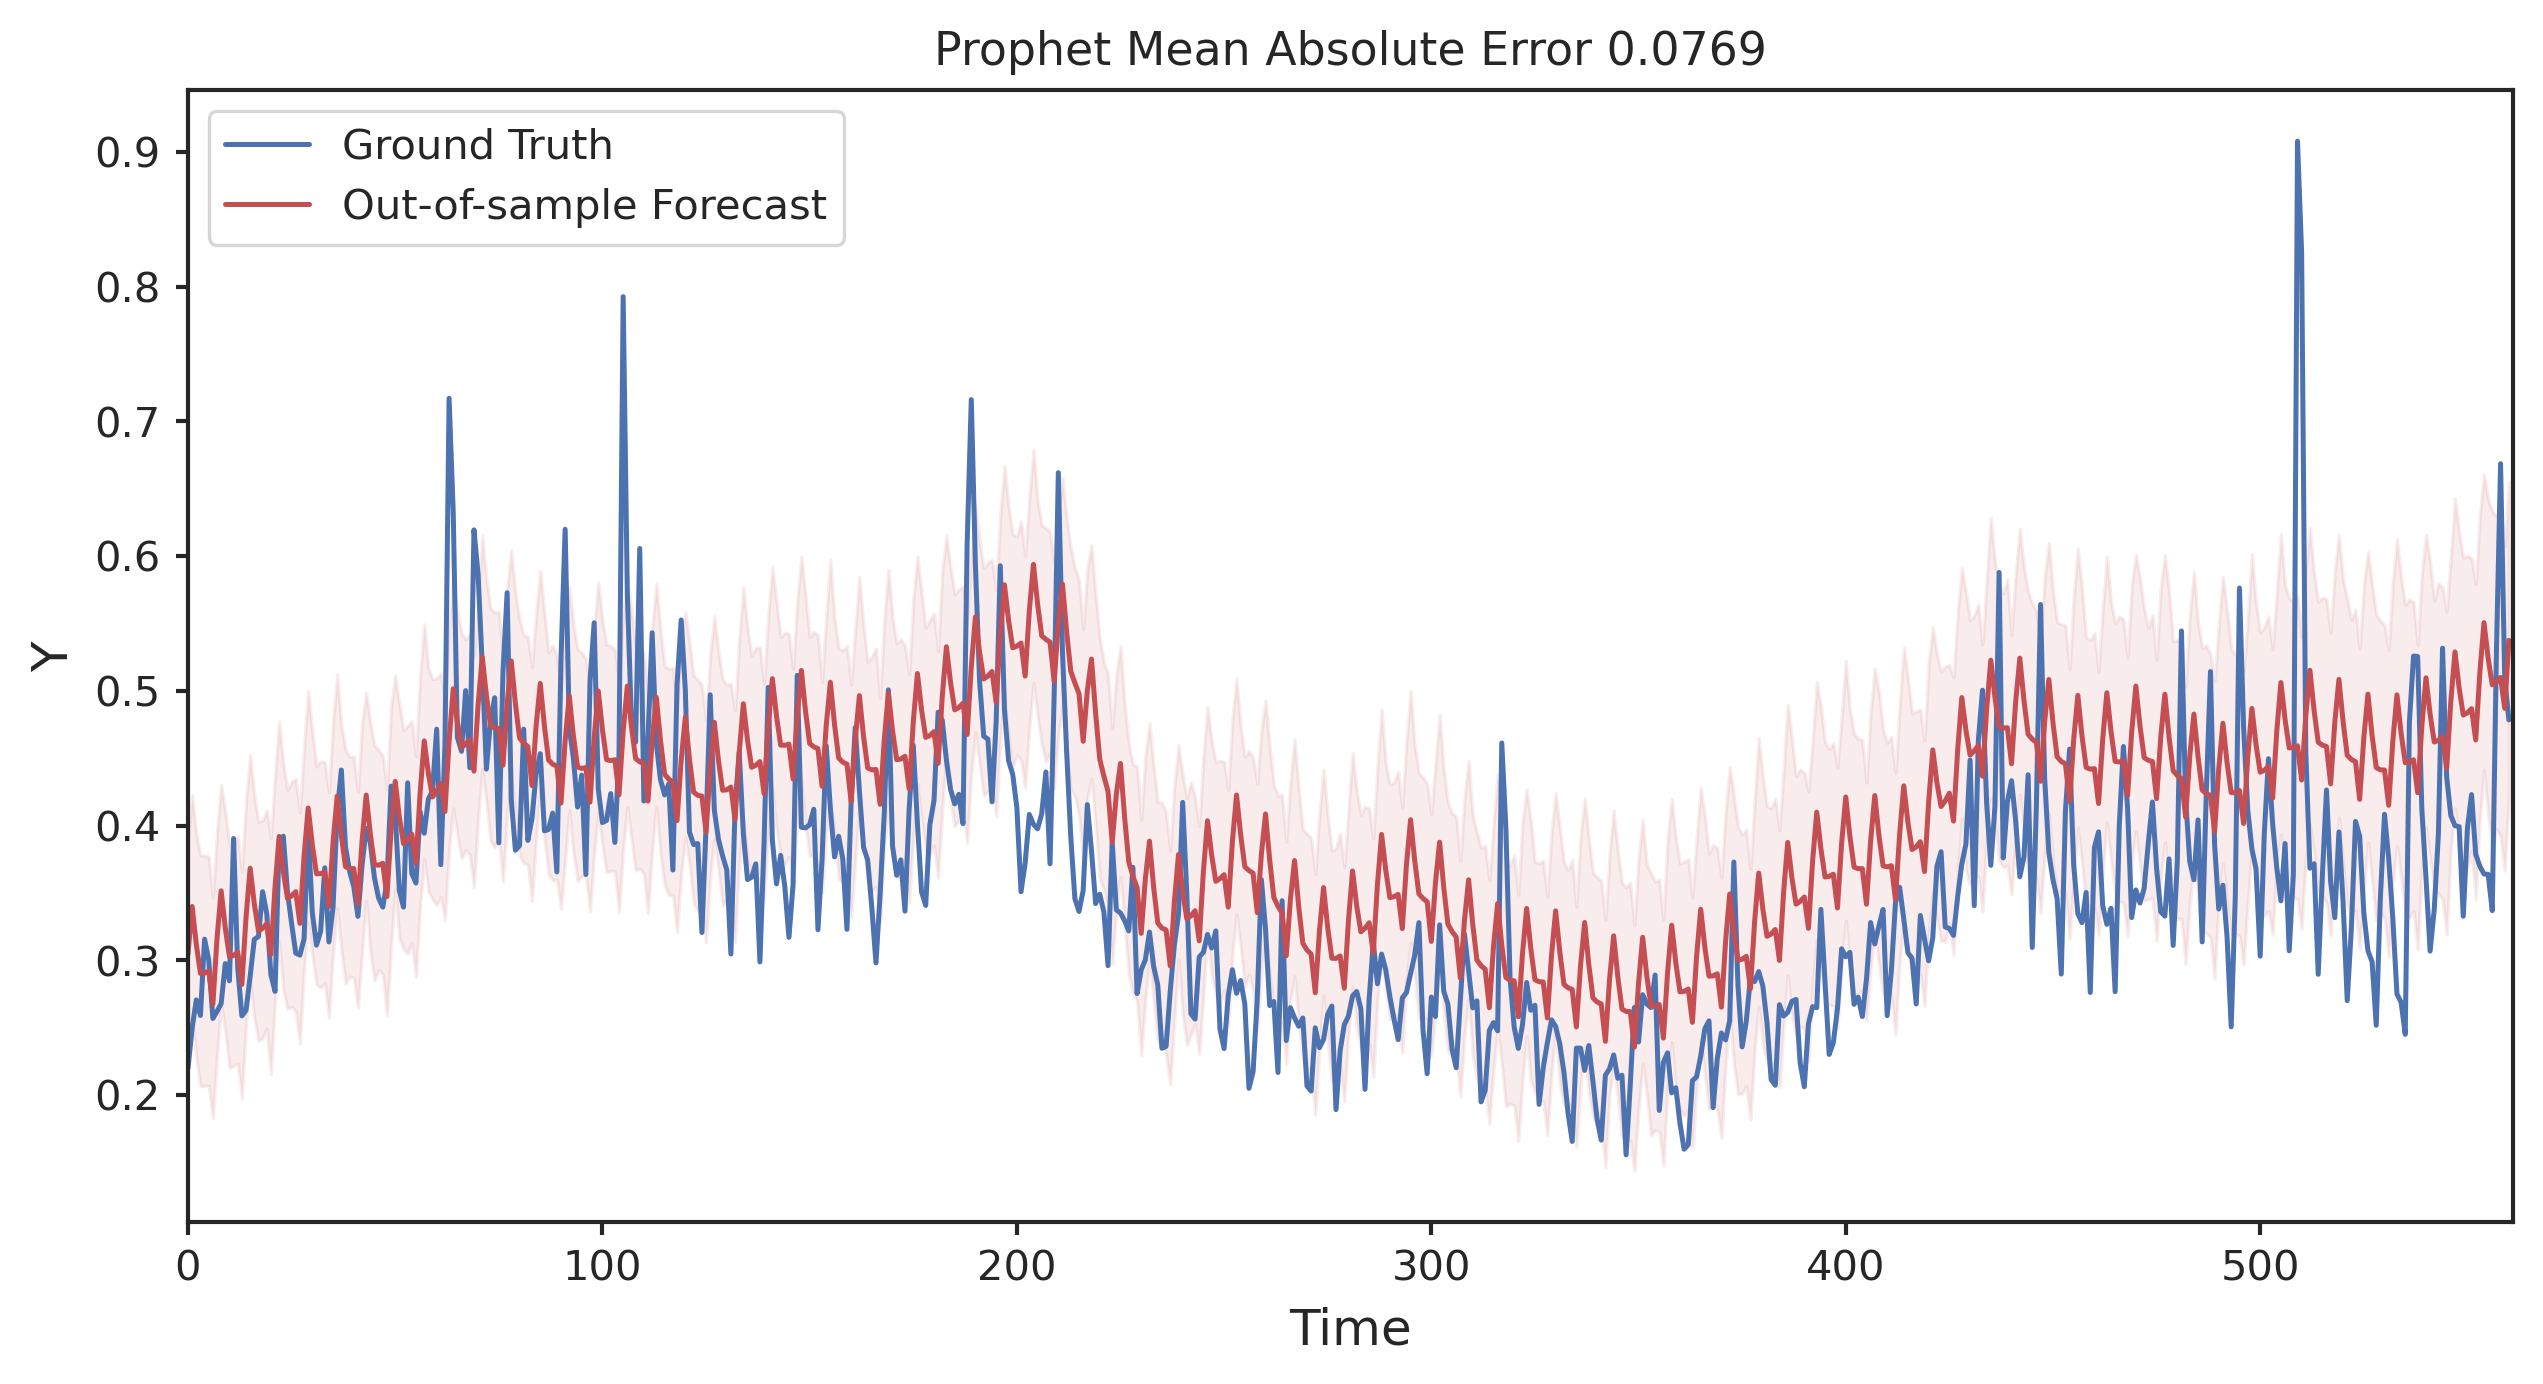

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(df['y'].values[-561:], label='Ground Truth')
plt.plot(
    mean_prediction, 
    label='Out-of-sample Forecast',
    color='r'
)
plt.fill_between(
    [i for i in range(len(mean_prediction))],
    upper_prediction,
    lower_prediction,
    color='r',
    alpha=0.1
)
plt.title(f'Prophet Mean Absolute Error {round(mae(y_ts, mean_prediction), 4)}')
plt.xlim(
    0,
    len(mean_prediction)
)
plt.ylabel('Y')
plt.xlabel('Time')
plt.legend()
plt.savefig(
    'results\\plots\\performance\\prophet_performance.svg'
)
plt.show()

## False Prophet

In [98]:
splitted_arrays = load_obj(
    path=f'data\\arrays\\peyton_manning'
)
splitted_arrays = splitted_arrays['test']

transformed = splitted_arrays['transformed'].reshape(-1, 1, 1)
month = splitted_arrays['month'].reshape(-1, 1)
day_week = splitted_arrays['day_week'].reshape(-1, 1)
day_month = splitted_arrays['day_month'].reshape(-1, 1)

X_ts = [
    transformed,
    month,
    day_week,
    day_month
]

y_ts = splitted_arrays['target'].flatten()

In [99]:
model = FalseProphet(
    X=transformed,
    batch_size=1
)
model.build()
model.load_weights()
forecast = model.predict_with_uncertainty(X_ts, n_boot=30, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [17:39<00:00, 35.30s/it]


In [102]:
mean_prediction = forecast.mean(axis=1)
upper_prediction = np.percentile(forecast, 92.5, axis=1)
lower_prediction = np.percentile(forecast, 2.5, axis=1)

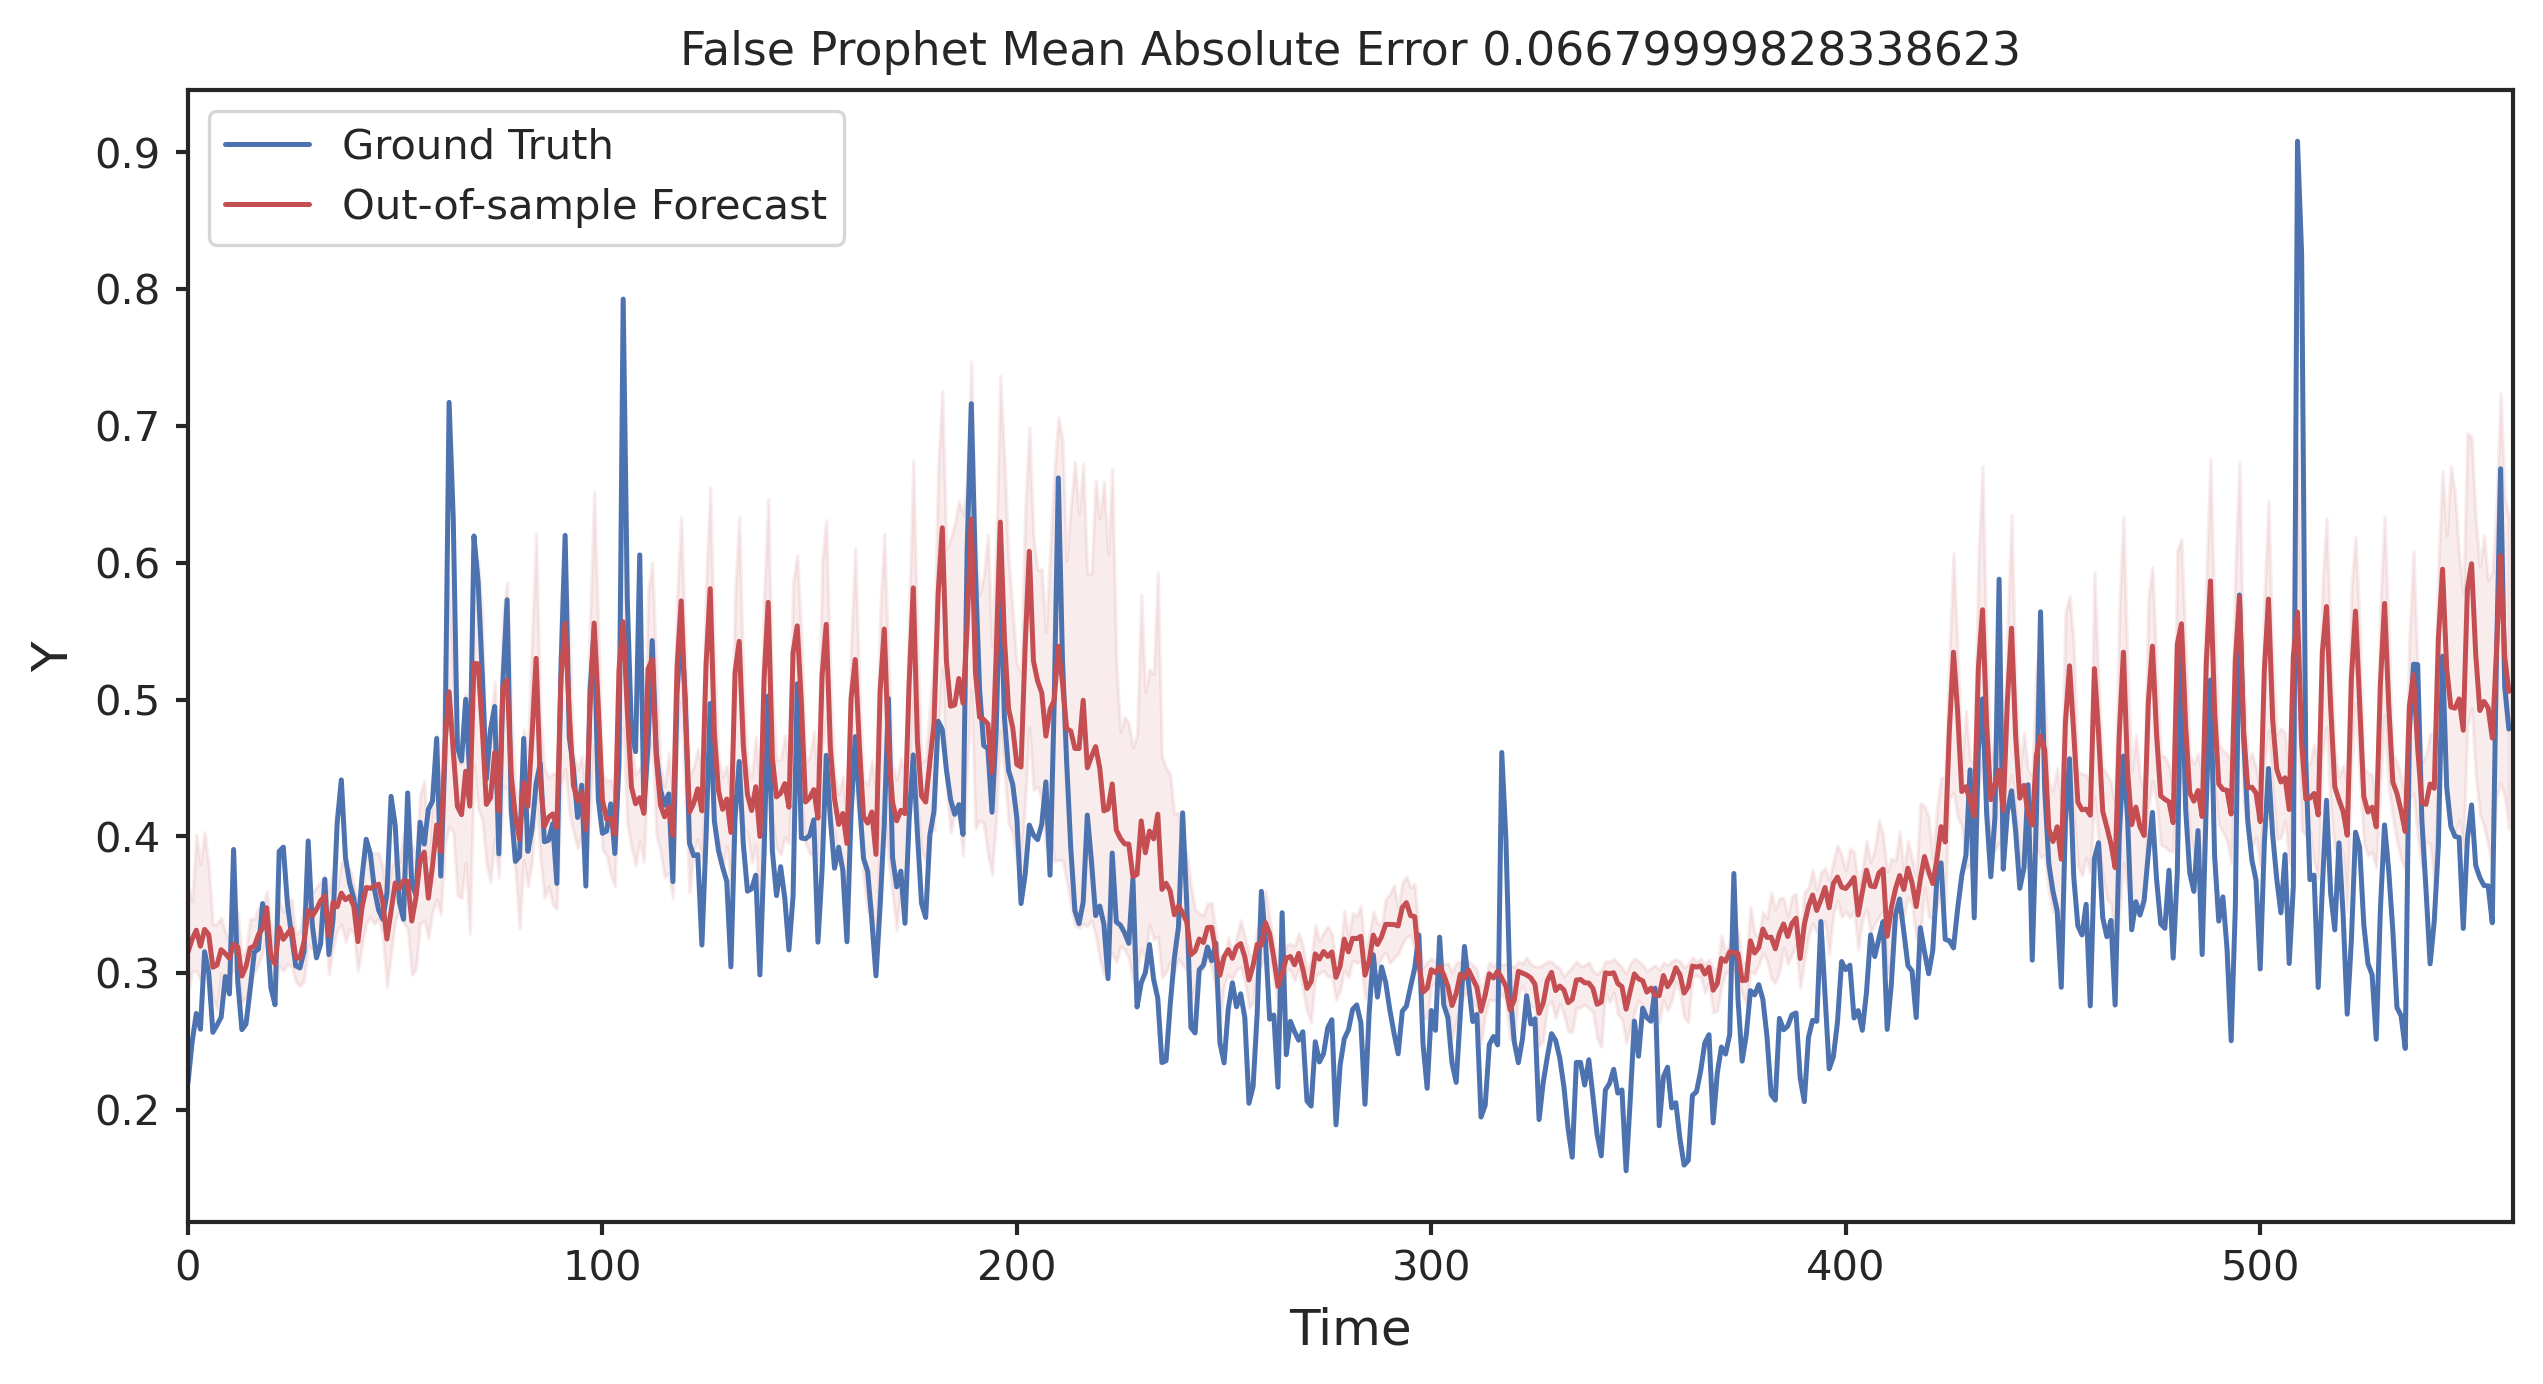

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(y_ts.flatten(), label='Ground Truth')
plt.plot(
    mean_prediction, 
    label='Out-of-sample Forecast',
    color='r'
)
plt.fill_between(
    [i for i in range(len(mean_prediction))],
    upper_prediction,
    lower_prediction,
    color='r',
    alpha=0.1
)
plt.title(f'False Prophet Mean Absolute Error {round(mae(y_ts, mean_prediction), 4)}')
plt.xlim(
    0,
    len(mean_prediction)
)
plt.ylabel('Y')
plt.xlabel('Time')
plt.legend()
plt.savefig(
    'results\\plots\\perfromance\\false_prophet_perfromance.svg'
)
plt.show()